# Image Space Projection using Autoencoders and MXNet
![](faces.gif)

Autoencoding is NOT YET SUPPORTED IN DEEPWATER

In this example we are going to autoencode the faces of the olivetti dataset and try to reconstruct them back.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 4 hours 15 mins
H2O cluster version:,3.11.0.99999
H2O cluster version age:,1 day
H2O cluster name:,fmilo
H2O cluster total nodes:,1
H2O cluster free memory:,9.36 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

We now need some code to read pgm files.
Thanks to [StackOverflow](http://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm) we have some code to leverage:

In [8]:
import re

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


In [9]:
image = read_pgm("orl_faces/s12/6.pgm", byteorder='<')

In [10]:
image.shape

(112, 92)

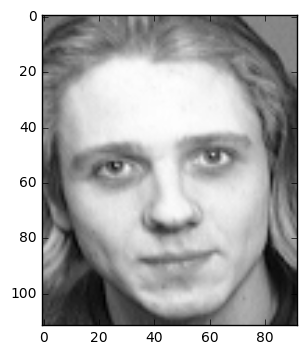

In [11]:
plt.imshow(image, plt.cm.gray)
plt.show()

In [12]:
import glob
import os
from collections import defaultdict

In [13]:
images = glob.glob("orl_faces/**/*.pgm")

data = defaultdict(list)
image_data = []
for img in images:
    _,label,_ = img.split(os.path.sep)
    imgdata = read_pgm(img, byteorder='<').flatten().tolist()
    data[label].append(imgdata)
    image_data.append(imgdata)

Let's import it to H2O

In [22]:
faces = h2o.H2OFrame.from_python(image_data)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [23]:
faces.shape

(400, 10304)

In [ ]:
try:
   import cPickle as pickle
except:
   import pickle

In [24]:
dl = H2ODeepWaterEstimator(
     # cross-validation
     nfolds=3,                                                          
     # network (fully-connected)
     hidden=[200,200], activation="Rectifier",                          
     # regularization
     hidden_dropout_ratios=[0.1,0.1], input_dropout_ratio=0.0,          
     # learning rate
     learning_rate=5e-3, learning_rate_annealing=1e-6,                                    
     # momentum
     momentum_start=0.9, momentum_stable=0.99, momentum_ramp=1e7,       
     # early stopping
     epochs=100, stopping_rounds=4, train_samples_per_iteration=30000,  
     # score often for early stopping
     mini_batch_size=32, score_duty_cycle=0.25, score_interval=1) 

In [28]:
dl.train(x=faces.names, training_frame=faces, )

ValueError: Missing response

## MXNet for DeepWater

Let's use mxnet

In [16]:
import mxnet as mx
import numpy as np

class AutoEncoderModel(object):
    
    def __init__(self, xpu=mx.cpu(), *args, **kwargs):
        self.xpu = xpu
        self.loss = None
        self.args = {}
        self.args_grad = {}
        self.args_mult = {}
        self.auxs = {}
        self.setup(*args, **kwargs)

    def save(self, fname):
        args_save = {key: v.asnumpy() for key, v in self.args.items()}
        with open(fname, 'w') as fout:
            pickle.dump(args_save, fout)

    def load(self, fname):
        with open(fname) as fin:
            args_save = pickle.load(fin)
            for key, v in args_save.items():
                if key in self.args:
                    self.args[key][:] = v

    def setup(self, dims, sparseness_penalty=None, pt_dropout=None, ft_dropout=None, input_act=None, internal_act='relu', output_act=None):
        self.N = len(dims) - 1
        self.dims = dims
        self.stacks = []
        self.pt_dropout = pt_dropout
        self.ft_dropout = ft_dropout
        self.input_act = input_act
        self.internal_act = internal_act
        self.output_act = output_act

        self.data = mx.symbol.Variable('data')
        for i in range(self.N):
            if i == 0:
                decoder_act = input_act
                idropout = None
            else:
                decoder_act = internal_act
                idropout = pt_dropout
            if i == self.N-1:
                encoder_act = output_act
                odropout = None
            else:
                encoder_act = internal_act
                odropout = pt_dropout
            istack, iargs, iargs_grad, iargs_mult, iauxs = self.make_stack(i, self.data, dims[i], dims[i+1],
                                                sparseness_penalty, idropout, odropout, encoder_act, decoder_act)
            self.stacks.append(istack)
            self.args.update(iargs)
            self.args_grad.update(iargs_grad)
            self.args_mult.update(iargs_mult)
            self.auxs.update(iauxs)
        self.encoder, self.internals = self.make_encoder(self.data, dims, sparseness_penalty, ft_dropout, internal_act, output_act)
        self.decoder = self.make_decoder(self.encoder, dims, sparseness_penalty, ft_dropout, internal_act, input_act)
        if input_act == 'softmax':
            self.loss = self.decoder
        else:
            self.loss = mx.symbol.LinearRegressionOutput(data=self.decoder, label=self.data)

    def make_stack(self, istack, data, num_input, num_hidden, sparseness_penalty=None, idropout=None,
                   odropout=None, encoder_act='relu', decoder_act='relu'):
        x = data
        if idropout:
            x = mx.symbol.Dropout(data=x, p=idropout)
        x = mx.symbol.FullyConnected(name='encoder_%d'%istack, data=x, num_hidden=num_hidden)
        if encoder_act:
            x = mx.symbol.Activation(data=x, act_type=encoder_act)
            if encoder_act == 'sigmoid' and sparseness_penalty:
                x = mx.symbol.IdentityAttachKLSparseReg(data=x, name='sparse_encoder_%d' % istack, penalty=sparseness_penalty)
        if odropout:
            x = mx.symbol.Dropout(data=x, p=odropout)
        x = mx.symbol.FullyConnected(name='decoder_%d'%istack, data=x, num_hidden=num_input)
        if decoder_act == 'softmax':
            x = mx.symbol.Softmax(data=x, label=data, prob_label=True, act_type=decoder_act)
        elif decoder_act:
            x = mx.symbol.Activation(data=x, act_type=decoder_act)
            if decoder_act == 'sigmoid' and sparseness_penalty:
                x = mx.symbol.IdentityAttachKLSparseReg(data=x, name='sparse_decoder_%d' % istack, penalty=sparseness_penalty)
            x = mx.symbol.LinearRegressionOutput(data=x, label=data)
        else:
            x = mx.symbol.LinearRegressionOutput(data=x, label=data)

        args = {'encoder_%d_weight'%istack: mx.nd.empty((num_hidden, num_input), self.xpu),
                'encoder_%d_bias'%istack: mx.nd.empty((num_hidden,), self.xpu),
                'decoder_%d_weight'%istack: mx.nd.empty((num_input, num_hidden), self.xpu),
                'decoder_%d_bias'%istack: mx.nd.empty((num_input,), self.xpu),}
        args_grad = {'encoder_%d_weight'%istack: mx.nd.empty((num_hidden, num_input), self.xpu),
                     'encoder_%d_bias'%istack: mx.nd.empty((num_hidden,), self.xpu),
                     'decoder_%d_weight'%istack: mx.nd.empty((num_input, num_hidden), self.xpu),
                     'decoder_%d_bias'%istack: mx.nd.empty((num_input,), self.xpu),}
        args_mult = {'encoder_%d_weight'%istack: 1.0,
                     'encoder_%d_bias'%istack: 2.0,
                     'decoder_%d_weight'%istack: 1.0,
                     'decoder_%d_bias'%istack: 2.0,}
        auxs = {}
        if encoder_act == 'sigmoid' and sparseness_penalty:
            auxs['sparse_encoder_%d_moving_avg' % istack] = mx.nd.ones((num_hidden), self.xpu) * 0.5
        if decoder_act == 'sigmoid' and sparseness_penalty:
            auxs['sparse_decoder_%d_moving_avg' % istack] = mx.nd.ones((num_input), self.xpu) * 0.5
        init = mx.initializer.Uniform(0.07)
        for k,v in args.items():
            init(k,v)

        return x, args, args_grad, args_mult, auxs

    def make_encoder(self, data, dims, sparseness_penalty=None, dropout=None, internal_act='relu', output_act=None):
        x = data
        internals = []
        N = len(dims) - 1
        for i in range(N):
            x = mx.symbol.FullyConnected(name='encoder_%d'%i, data=x, num_hidden=dims[i+1])
            if internal_act and i < N-1:
                x = mx.symbol.Activation(data=x, act_type=internal_act)
                if internal_act=='sigmoid' and sparseness_penalty:
                    x = mx.symbol.IdentityAttachKLSparseReg(data=x, name='sparse_encoder_%d' % i, penalty=sparseness_penalty)
            elif output_act and i == N-1:
                x = mx.symbol.Activation(data=x, act_type=output_act)
                if output_act=='sigmoid' and sparseness_penalty:
                    x = mx.symbol.IdentityAttachKLSparseReg(data=x, name='sparse_encoder_%d' % i, penalty=sparseness_penalty)
            if dropout:
                x = mx.symbol.Dropout(data=x, p=dropout)
            internals.append(x)
        return x, internals

    def make_decoder(self, feature, dims, sparseness_penalty=None, dropout=None, internal_act='relu', input_act=None):
        x = feature
        N = len(dims) - 1
        for i in reversed(range(N)):
            x = mx.symbol.FullyConnected(name='decoder_%d'%i, data=x, num_hidden=dims[i])
            if internal_act and i > 0:
                x = mx.symbol.Activation(data=x, act_type=internal_act)
                if internal_act=='sigmoid' and sparseness_penalty:
                    x = mx.symbol.IdentityAttachKLSparseReg(data=x, name='sparse_decoder_%d' % i, penalty=sparseness_penalty)
            elif input_act and i == 0:
                x = mx.symbol.Activation(data=x, act_type=input_act)
                if input_act=='sigmoid' and sparseness_penalty:
                    x = mx.symbol.IdentityAttachKLSparseReg(data=x, name='sparse_decoder_%d' % i, penalty=sparseness_penalty)
            if dropout and i > 0:
                x = mx.symbol.Dropout(data=x, p=dropout)
        return x

In [17]:
ae_model = AutoEncoderModel(mx.gpu(0), [784,500,500,2000,10], pt_dropout=0.2,
        internal_act='relu', output_act='relu')

In [18]:
ae_model.save('mnist_pt.arg')

NameError: global name 'pickle' is not defined

In [223]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

In [ ]:
model = H2OAutoEncoderEstimator( 
        activation="Tanh", 
        hidden=[500, 100, 500], 
        sparse=True,
        l1=1e-4, 
        epochs=100
)

model.train(x=faces.names, training_frame=faces)

deeplearning Model Build progress: |███████

## Encoded Images

What are the main features of the image ? Let's try to feed the neural network with a test image and see what is the result

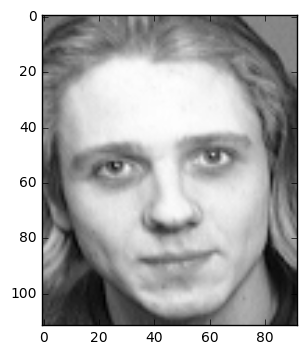

In [168]:
image = read_pgm("orl_faces/s12/6.pgm", byteorder='<')
plt.imshow(image, plt.cm.gray)

In [183]:
image = image.flatten()

In [198]:
df = pd.DataFrame([image], columns=faces.names)

In [199]:
image_hf = h2o.H2OFrame.from_python(df)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [200]:
image_hf.shape

(1, 10304)

In [201]:
encoded_image = model.predict(image_hf)

deeplearning prediction progress: |███████████████████████████████████████████████████████████| 100%


In [202]:
encoded_image.shape

(1, 10304)

In [207]:
image = encoded_image.as_data_frame()

/home/fmilo/anaconda2/envs/deepwater/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


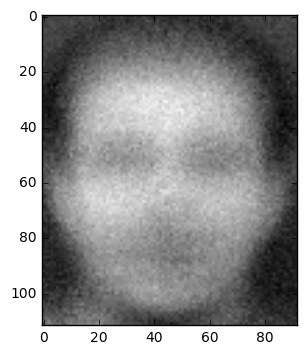

In [222]:
plt.imshow(image[0].reshape(112,92), plt.cm.gray);

## Reconstructing the hidden space

Now that we have our model trained, we would like to understand better what is the internal representation of this model? What makes a face a .. face? 

We will provide to the model some gaussian noise and see what is the results.

We star by creating some gaussian noise:

In [145]:
import pandas as pd

In [146]:
gaussian_noise = np.random.randn(10304)

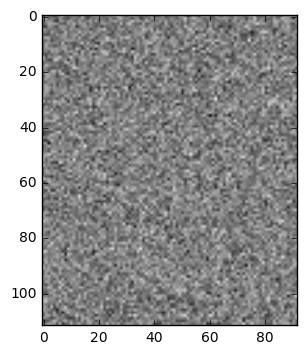

In [147]:
plt.imshow(gaussian_noise.reshape(112, 92), plt.cm.gray);

Then we import this data inside H2O. We have to first map the columns to the gaussian data.

In [149]:
gaussian_noise_pre = dict(zip(faces.names,gaussian_noise))

In [150]:
gaussian_noise_hf = h2o.H2OFrame.from_python(gaussian_noise_pre)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [151]:
result = model.anomaly(gaussian_noise_hf)

In [152]:
result = model.predict(gaussian_noise_hf)

deeplearning prediction progress: |███████████████████████████████████████████████████████████| 100%


In [153]:
result.shape

(1, 10304)

In [154]:
img = result.as_data_frame()

In [155]:
img_data = img.T.values.reshape(112, 92)

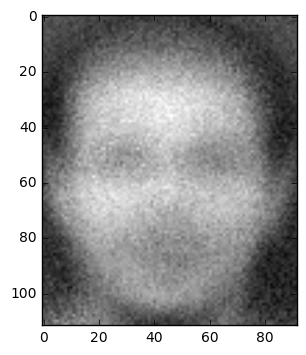

In [156]:
plt.imshow(img_data, plt.cm.gray);